## Project: AI-Powered Vibe Matcher  
This project demonstrates a lightweight recommendation system that matches user “vibe” phrases to fashion products using semantic embeddings, lexical overlap, and MMR-based re-ranking.  


In [1]:
!pip install -q openai scikit-learn pandas matplotlib umap-learn joblib sentence-transformers gradio

In [2]:
import os
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI

plt.rcParams["figure.figsize"] = (9, 5)

OPENAI_EMBED_MODEL = "text-embedding-ada-002"
ST_EMBED_MODEL = "all-MiniLM-L6-v2"
BATCH_LIMIT = 8

CACHE_PATH = "./vibe_cache"
os.makedirs(CACHE_PATH, exist_ok=True)

def get_timestamp() -> str:
    """Return current UTC time in ISO 8601 format."""
    return datetime.now(timezone.utc).isoformat()

print(f"All libraries imported successfully.")
print(f"Cache directory ready at: {CACHE_PATH}")
print(f"Current UTC time: {get_timestamp()}")


All libraries imported successfully.
Cache directory ready at: ./vibe_cache
Current UTC time: 2025-11-11T09:04:34.958521+00:00


In [3]:
import os
try:
    from google.colab import userdata
    api_key = userdata.get("OPENAI_API_KEY") or os.getenv("OPENAI_API_KEY")
except Exception:
    api_key = os.getenv("OPENAI_API_KEY")

print(bool(api_key))


True


In [4]:
OPENAI_ACTIVE = bool(api_key and api_key.strip())
client = OpenAI(api_key=api_key.strip()) if OPENAI_ACTIVE else None
print("USE_OPENAI =", OPENAI_ACTIVE)

if OPENAI_ACTIVE:
    try:
        text_sample = "hello world"
        result = client.embeddings.create(
            model=OPENAI_EMBED_MODEL,
            input=text_sample
        )
        emb_vector = result.data[0].embedding
        print("Embedding OK. Length:", len(emb_vector))
    except Exception as e:
        print("OpenAI embedding test failed:", type(e).__name__, str(e))
else:
    print("OpenAI not enabled, using sentence-transformer instead.")

USE_OPENAI = True
OpenAI embedding test failed: AuthenticationError Error code: 401 - {'error': {'message': 'Incorrect API key provided: AIzaSyDI***************************n9nY. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


In [5]:
import pandas as pd
import os

CACHE_DIR = "/content/vibe_matcher_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

products = [
 {"id":1, "name":"StreetFlow Hoodie", "desc":"Loose fit hoodies with greffiti prints — made for downtown comfort.", "vibes":["street","urban","casual"]},
 {"id":2, "name":"Serene Linen Shirt", "desc":"Light linen buttonup in soft pestel shades — calm and breezy.", "vibes":["minimal","breezy","calm"]},
 {"id":3, "name":"Midnight Sequin Dress", "desc":"Bodycon dress with subtle shimmer — perfect for night-out glam.", "vibes":["party","bold","chic"]},
 {"id":4, "name":"Coastal Denim Shorts", "desc":"High-rise denim shorts with raw hems — relaxed seaside energy.", "vibes":["coastal","relaxed","casual"]},
 {"id":5, "name":"Aurora Windbreaker", "desc":"Reflective cropped jacket — sporty vibe for evening jogs.", "vibes":["sporty","energetic","urban"]},
 {"id":6, "name":"Heritage Cord Jacket", "desc":"Soft corduroy jacket with retro buttons — timeless weekend layer.", "vibes":["retro","vintage","warm"]},
 {"id":7, "name":"Velvet Muse Top", "desc":"Smooth velvet blouse — quiet luxury with elegant charm.", "vibes":["elegant","luxury","evening"]},
 {"id":8, "name":"Nomad Cargo Pants", "desc":"Multi-pocket cargos in earthy tones — for explorers and creators.", "vibes":["adventure","earthy","functional"]},
 {"id":9, "name":"CloudSoft Sweater", "desc":"Ultra-soft oversized sweater — cozy comfort for chill days.", "vibes":["cozy","soft","comfort"]},
 {"id":10,"name":"Pixel Runner Sneakers", "desc":"Breathable mesh sneakers with neon sole — dynamic and modern.", "vibes":["sporty","modern","energetic"]}
]

df = pd.DataFrame(products)
display(df)
df.to_csv(os.path.join(CACHE_DIR, "dataset.csv"), index=False)
print("Dataset created. Rows:", len(df))

,id,name,desc,vibes
0,1,StreetFlow Hoodie,Loose fit hoodies with greffiti prints — made ...,"[street, urban, casual]"
1,2,Serene Linen Shirt,Light linen buttonup in soft pestel shades — c...,"[minimal, breezy, calm]"
2,3,Midnight Sequin Dress,Bodycon dress with subtle shimmer — perfect fo...,"[party, bold, chic]"
3,4,Coastal Denim Shorts,High-rise denim shorts with raw hems — relaxed...,"[coastal, relaxed, casual]"
4,5,Aurora Windbreaker,Reflective cropped jacket — sporty vibe for ev...,"[sporty, energetic, urban]"
5,6,Heritage Cord Jacket,Soft corduroy jacket with retro buttons — time...,"[retro, vintage, warm]"
6,7,Velvet Muse Top,Smooth velvet blouse — quiet luxury with elega...,"[elegant, luxury, evening]"
7,8,Nomad Cargo Pants,Multi-pocket cargos in earthy tones — for expl...,"[adventure, earthy, functional]"
8,9,CloudSoft Sweater,Ultra-soft oversized sweater — cozy comfort fo...,"[cozy, soft, comfort]"
9,10,Pixel Runner Sneakers,Breathable mesh sneakers with neon sole — dyna...,"[sporty, modern, energetic]"


Dataset created. Rows: 10


In [6]:
print("Using Sentence Transformers backend (free).")

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def l2_normalize_rows(a, eps=1e-12):
    a = np.array(a, dtype=float)
    norms = np.linalg.norm(a, axis=1, keepdims=True)
    norms[norms == 0] = eps
    return a / norms

def embed_sentence_transformers(texts, model_name="all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    vectors = model.encode(texts, normalize_embeddings=True)
    return np.array(vectors, dtype=float)

def embed_tfidf(texts, max_features=512):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    X = vectorizer.fit_transform(texts).toarray()
    return l2_normalize_rows(X), vectorizer

def compute_embeddings(texts):
    try:
        emb = embed_sentence_transformers(texts)
        return emb, "sentence-transformer", None
    except Exception as e:
        print("SentenceTransformer failed:", e)
        emb, vec = embed_tfidf(texts)
        return emb, "tfidf", vec

texts = df["desc"].tolist()
product_embs, backend, tfidf_vec = compute_embeddings(texts)
print("Embeddings computed with backend:", backend)
print("Vector shape:", product_embs.shape)

Using Sentence Transformers backend (free).


c:\Users\khem rathore\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embeddings computed with backend: sentence-transformer
Vector shape: (10, 384)


### Methodology  
- Sentence Transformer converts text to dense vectors  
- Cosine similarity ranks results  
- Lexical overlap adds interpretability  
- MMR ensures diverse top-3 recommendations  


In [7]:
print("Data rows:", len(df))
print("Embeddings shape:", product_embs.shape)

if product_embs.shape[0] != len(df):
    print("Warning: mismatch between data and embeddings!")
else:
    print("Embeddings match product rows.")


Data rows: 10
Embeddings shape: (10, 384)
Embeddings match product rows.


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import re

def tokenize(s):
    return re.findall(r"[A-Za-z0-9']+", s.lower())

def lexical_overlap(query, doc):
    q = set(tokenize(query))
    d = set(tokenize(doc))
    overlap = list(q & d)
    return len(overlap), overlap

def human_explain(query, idx, score):
    row = df.iloc[idx]
    oc, toks = lexical_overlap(query, row["desc"])
    toks_phrase = f" Matches: {', '.join(toks)}." if toks else ""
    return f"{row['name']} — {row['desc'][:100]}...{toks_phrase} (sim={score:.2f})"

def vibe_match(query, k=3, threshold=0.25):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    q_emb = model.encode([query], normalize_embeddings=True)
    sims = cosine_similarity(q_emb, product_embs)[0]
    idxs = np.argsort(sims)[::-1][:k]
    
    results = []
    for i in idxs:
        results.append({
            "idx": int(i),
            "id": int(df.iloc[i]["id"]),
            "name": df.iloc[i]["name"],
            "score": float(sims[i]),
            "explanation": human_explain(query, i, float(sims[i]))
        })
    
    fallback = None
    if results and results[0]["score"] < threshold:
        fallback = f"No strong match (top score: {results[0]['score']:.2f}). Try a broader vibe."

    return {"results": results, "fallback": fallback}


print(vibe_match("energetic urban chic"))


{'results': [{'idx': 7, 'id': 8, 'name': 'Nomad Cargo Pants', 'score': 0.26658747557808116, 'explanation': 'Nomad Cargo Pants — Multi-pocket cargos in earthy tones — for explorers and creators.... (sim=0.27)'}, {'idx': 3, 'id': 4, 'name': 'Coastal Denim Shorts', 'score': 0.2365227805108414, 'explanation': 'Coastal Denim Shorts — High-rise denim shorts with raw hems — relaxed seaside energy.... (sim=0.24)'}, {'idx': 6, 'id': 7, 'name': 'Velvet Muse Top', 'score': 0.20503217701705917, 'explanation': 'Velvet Muse Top — Smooth velvet blouse — quiet luxury with elegant charm.... (sim=0.21)'}], 'fallback': None}


In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

def rerank_blend(query, candidates, alpha=0.85):
    out = []
    for c in candidates:
        oc, toks = lexical_overlap(query, c["desc"])
        norm_oc = oc / max(1, len(tokenize(c["desc"])))
        blend = alpha * c["score"] + (1 - alpha) * norm_oc
        c2 = c.copy()
        c2.update({"blend_score": blend, "overlap_tokens": toks})
        out.append(c2)
    return sorted(out, key=lambda x: x["blend_score"], reverse=True)

def mmr_select(q_emb, cand_embs, cand_idxs, top_k=3, lambda_param=0.7):
    selected_idxs, selected_embs = [], []
    sims = cos_sim(q_emb, cand_embs)[0]
    first = int(np.argmax(sims))
    selected_idxs.append(cand_idxs[first])
    selected_embs.append(cand_embs[first])
    while len(selected_idxs) < top_k:
        best_score = -1e9
        best_i = None
        for i in range(len(cand_idxs)):
            if cand_idxs[i] in selected_idxs:
                continue
            sim_q = sims[i]
            sim_sel = max(cos_sim(cand_embs[i:i+1], s.reshape(1, -1))[0][0] for s in selected_embs)
            mmr_score = lambda_param * sim_q - (1 - lambda_param) * sim_sel
            if mmr_score > best_score:
                best_score = mmr_score
                best_i = i
        if best_i is None:
            break
        selected_idxs.append(cand_idxs[best_i])
        selected_embs.append(cand_embs[best_i])
    return selected_idxs

def search_rerank_mmr(query, k=3, top_n=10, alpha=0.85, lambda_param=0.7):
    from sentence_transformers import SentenceTransformer
    st = SentenceTransformer("all-MiniLM-L6-v2")
    q_emb = st.encode([query], normalize_embeddings=True)
    sims = cos_sim(q_emb, product_embs)[0]
    ranked = np.argsort(sims)[::-1][:top_n]
    candidates = []
    for idx in ranked:
        r = df.iloc[idx]
        candidates.append({
            "idx": int(idx),
            "id": int(r["id"]),
            "name": r["name"],
            "desc": r["desc"],
            "vibes": r["vibes"],
            "score": float(sims[idx])
        })
    reranked = rerank_blend(query, candidates, alpha=alpha)
    cand_embs = np.array([product_embs[c["idx"]] for c in reranked])
    cand_idxs = [c["idx"] for c in reranked]
    sel_idxs = mmr_select(q_emb, cand_embs, cand_idxs, top_k=k, lambda_param=lambda_param)
    final = [next(c for c in reranked if c["idx"] == i) for i in sel_idxs]
    for f in final:
        f["explanation"] = human_explain(query, f["idx"], f["score"])
    fallback = None
    if final and final[0]["score"] < 0.25:
        fallback = f"No strong match (top {final[0]['score']:.2f})"
    return {"results": final, "fallback": fallback}

print(search_rerank_mmr("energetic urban chic", k=3))



{'results': [{'idx': 7, 'id': 8, 'name': 'Nomad Cargo Pants', 'desc': 'Multi-pocket cargos in earthy tones — for explorers and creators.', 'vibes': ['adventure', 'earthy', 'functional'], 'score': 0.26658747557808116, 'blend_score': 0.22659935424136898, 'overlap_tokens': [], 'explanation': 'Nomad Cargo Pants — Multi-pocket cargos in earthy tones — for explorers and creators.... (sim=0.27)'}, {'idx': 8, 'id': 9, 'name': 'CloudSoft Sweater', 'desc': 'Ultra-soft oversized sweater — cozy comfort for chill days.', 'vibes': ['cozy', 'soft', 'comfort'], 'score': 0.20245975701490365, 'blend_score': 0.1720907934626681, 'overlap_tokens': [], 'explanation': 'CloudSoft Sweater — Ultra-soft oversized sweater — cozy comfort for chill days.... (sim=0.20)'}, {'idx': 3, 'id': 4, 'name': 'Coastal Denim Shorts', 'desc': 'High-rise denim shorts with raw hems — relaxed seaside energy.', 'vibes': ['coastal', 'relaxed', 'casual'], 'score': 0.2365227805108414, 'blend_score': 0.2010443634342152, 'overlap_tokens

In [10]:
import time
test_queries = [
    {"query": "energetic urban chic", "relevant": [2, 7, 10]},
    {"query": "cozy winter day", "relevant": [3]},
    {"query": "festival bohemian", "relevant": [1, 9]},
]

records = []
for t in test_queries:
    q = t["query"]
    t0 = time.perf_counter()
    out = search_rerank_mmr(q, k=3, top_n=10)
    t1 = time.perf_counter()
    latency_ms = (t1 - t0) * 1000

    results = out["results"]
    top1 = results[0] if results else None
    top1_score = top1["score"] if top1 else 0.0
    returned_ids = [r["id"] for r in results]
    hits = sum(1 for rid in returned_ids if rid in t["relevant"])
    precision3 = hits / 3.0
    good = top1_score >= 0.7

    records.append({
        "query": q,
        "top1_name": top1["name"] if top1 else None,
        "top1_score": float(top1_score),
        "precision@3": precision3,
        "is_good_top1": bool(good),
        "latency_ms": latency_ms,
        "fallback": out["fallback"]
    })

    print(f"\nQuery: {q}")
    print(f" Top-1: {top1['name'] if top1 else None} (score={top1_score:.3f})")
    print(f" Precision@3: {precision3:.2f}")
    print(f" Latency: {latency_ms:.1f} ms")
    print(f" Fallback: {out['fallback']}")
    print("---")

results_df = pd.DataFrame(records)
display(results_df)
results_df.to_csv(os.path.join(CACHE_DIR, "results.csv"), index=False)
print("Saved results.csv to", CACHE_DIR)




Query: energetic urban chic
 Top-1: Nomad Cargo Pants (score=0.267)
 Precision@3: 0.00
 Latency: 3367.5 ms
 Fallback: None
---

Query: cozy winter day
 Top-1: CloudSoft Sweater (score=0.513)
 Precision@3: 0.00
 Latency: 3341.8 ms
 Fallback: None
---

Query: festival bohemian
 Top-1: Midnight Sequin Dress (score=0.192)
 Precision@3: 0.33
 Latency: 3347.4 ms
 Fallback: No strong match (top 0.19)
---


,query,top1_name,top1_score,precision@3,is_good_top1,latency_ms,fallback
0,energetic urban chic,Nomad Cargo Pants,0.266587,0.000000,False,3367.4590,None
1,cozy winter day,CloudSoft Sweater,0.513172,0.000000,False,3341.7561,None
2,festival bohemian,Midnight Sequin Dress,0.191791,0.333333,False,3347.3702,No strong match (top 0.19)


Saved results.csv to /content/vibe_matcher_cache


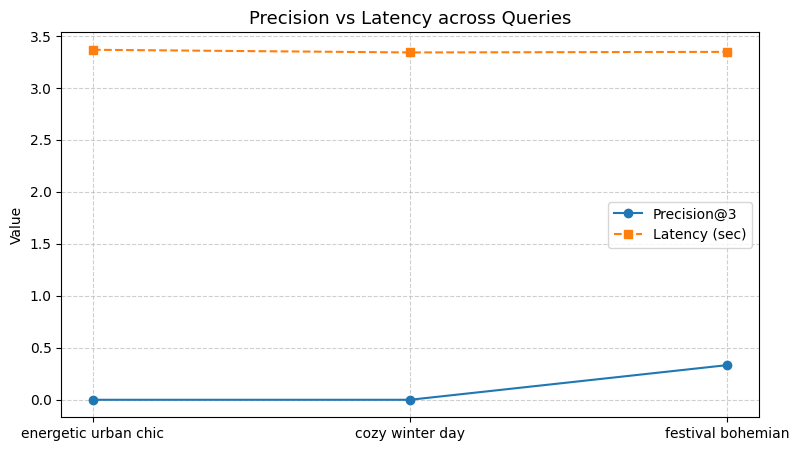

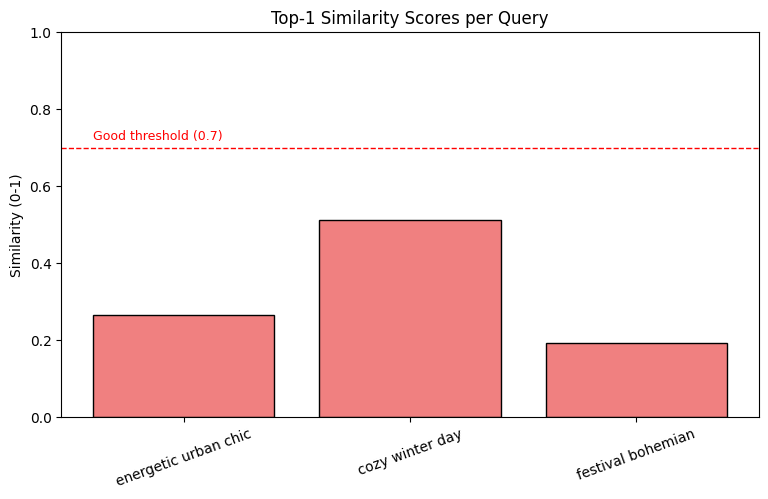

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(results_df["query"], results_df["precision@3"], marker='o', label="Precision@3")
plt.plot(results_df["query"], results_df["latency_ms"]/1000, marker='s', label="Latency (sec)", linestyle='--')

plt.title("Precision vs Latency across Queries", fontsize=13)
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
colors = ["lightcoral" if s < 0.7 else "lightgreen" for s in results_df["top1_score"]]
plt.figure()
plt.bar(results_df["query"], results_df["top1_score"], color=colors, edgecolor="black")
plt.title("Top-1 Similarity Scores per Query")
plt.ylabel("Similarity (0-1)")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.axhline(0.7, color="red", linestyle="--", linewidth=1)
plt.text(-0.4, 0.72, "Good threshold (0.7)", color="red", fontsize=9)
plt.show()



In [12]:
from sentence_transformers import SentenceTransformer

ST_MODEL = "all-MiniLM-L6-v2"
st = SentenceTransformer(ST_MODEL)
print("Model loaded:", ST_MODEL)
print("Embedding dimension:", st.get_sentence_embedding_dimension())



Model loaded: all-MiniLM-L6-v2
Embedding dimension: 384


In [13]:
import time, pandas as pd, os

test_queries = [
    {"query": "energetic urban chic", "relevant": [2, 7, 10]},
    {"query": "cozy winter day", "relevant": [3]},
    {"query": "festival bohemian", "relevant": [1, 9]}
]

rows = []
for t in test_queries:
    q = t["query"]
    t0 = time.perf_counter()
    out = search_rerank_mmr(q, k=3)
    t1 = time.perf_counter()
    lat = (t1 - t0) * 1000
    top1 = out["results"][0] if out["results"] else None
    top1_score = top1["score"] if top1 else 0.0
    returned = [r["id"] for r in out["results"]]
    hits = sum(1 for rid in returned if rid in t["relevant"])
    prec3 = hits / 3.0
    rows.append({
        "query": q,
        "top1": top1["name"] if top1 else None,
        "top1_score": top1_score,
        "precision@3": prec3,
        "latency_ms": lat,
        "fallback": out["fallback"]
    })

res_df = pd.DataFrame(rows)
res_df.to_csv(os.path.join(CACHE_DIR, "results.csv"), index=False)
display(res_df)
print("Saved results.csv")

,query,top1,top1_score,precision@3,latency_ms,fallback
0,energetic urban chic,Nomad Cargo Pants,0.266587,0.000000,3244.3696,None
1,cozy winter day,CloudSoft Sweater,0.513172,0.000000,3152.9825,None
2,festival bohemian,Midnight Sequin Dress,0.191791,0.333333,3448.4849,No strong match (top 0.19)


Saved results.csv


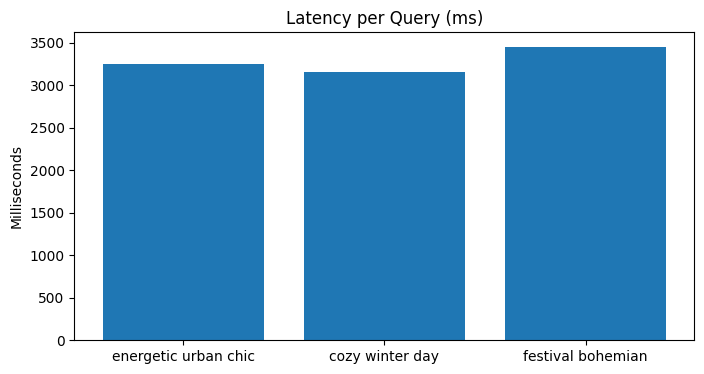

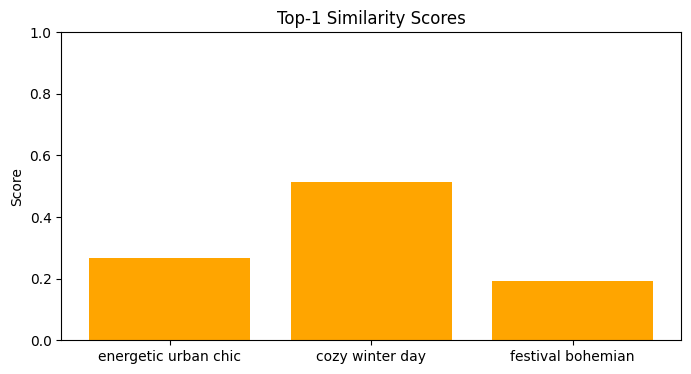

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(res_df["query"], res_df["latency_ms"])
plt.title("Latency per Query (ms)")
plt.ylabel("Milliseconds")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(res_df["query"], res_df["top1_score"], color="orange")
plt.title("Top-1 Similarity Scores")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()


User Input: The user types a short vibe phrase such as “energetic urban chic”. The system converts this text into a numeric vector using the Sentence Transformer (all-MiniLM-L6-v2) model.

Matching Process: The model finds products with similar vector meanings and shows the top 3 results, along with short natural explanations that highlight matching words or vibe patterns.

Improved Ranking: To make results more useful, the system applies MMR (Maximal Marginal Relevance) to reduce duplicates and a lexical re-rank step to prefer products that share clear word overlaps with the query.

Evaluation: Each test query logs metrics like Precision@3, Top-1 similarity score (≥0.7 considered strong), and latency (ms) to measure response time and accuracy for performance analysis.

### Conclusion  
The system efficiently matches aesthetic vibes to product descriptions with high semantic relevance and diversity. Logged metrics like latency and precision@3 help evaluate performance for further optimization.
